In [3]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [5]:
len(words)

32033

In [6]:
chars = sorted(list(set(''.join(words))))
stoi = { s: i + 1 for i, s in enumerate(chars) }
stoi['.'] = 0
itos = { i: s for s, i in stoi.items() }
itos

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

In [7]:
block_size = 3

def build_dataset(words):
    X, Y = [], []
    
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
            
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    
    return X, Y

In [8]:
import random
random.seed(42)

In [9]:
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr,  Ytr  = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte,  Yte  = build_dataset(words[n2:])

In [10]:
# Our previous MLP implementation
vocab_size = len(stoi)
n_embed = 10 # the dimensions for character embedding in a vector
n_hidden = 200 # number of neurons in the hidden layer

g  = torch.Generator().manual_seed(2147483647)
C  = torch.randn((vocab_size, n_embed),    generator = g) # our initial lookup table (an n_embed dimensional embedding)
W1 = torch.randn((n_embed * block_size, n_hidden),      generator = g) * 0.2 # our hidden layer matrix
b1 = torch.randn(n_hidden,                 generator = g) * 0.01 # our biases 
W2 = torch.randn((n_hidden, vocab_size),   generator = g) * 0.01 # our output layer
b2 = torch.randn(vocab_size,               generator = g) * 0

# batch normalization
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnrunning_mean = torch.zeros((1, n_hidden))
bnrunning_std = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

12297


In [11]:
hpreact.shape

NameError: name 'hpreact' is not defined

In [ ]:
hpreact.mean(0, keepdim=True).shape

In [ ]:
hpreact.std(0, keepdim=True).shape

In [12]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # create our mini-batch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y
    
    # forward pass
    emb = C[Xb]                         # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concat the vectors
    hpreact = embcat @ W1 + b1          # hidden layer pre-activation
    
    # batch normalization
    # each neuron will be normalized to a gaussain distribution
    hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
    
    # update our running mean
    with torch.no_grad():
        bnrunning_mean = 0.999 * bnrunning_mean + 0.001 * hpreact.mean(0, keepdim=True)
        bnrunning_std  = 0.999 * bnrunning_std + 0.001 * hpreact.std(0, keepdim=True)
    
    h = torch.tanh(hpreact)
    
    logits = h @ W2 + b2                # output layer
    loss = F.cross_entropy(logits, Yb)  # loss function
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.3147
  10000/ 200000: 2.1341
  20000/ 200000: 2.3173
  30000/ 200000: 2.4115
  40000/ 200000: 2.0124
  50000/ 200000: 2.3003
  60000/ 200000: 2.4708
  70000/ 200000: 2.1208
  80000/ 200000: 2.3562
  90000/ 200000: 2.1095
 100000/ 200000: 1.9329
 110000/ 200000: 2.3919
 120000/ 200000: 1.9795
 130000/ 200000: 2.4764
 140000/ 200000: 2.3703
 150000/ 200000: 2.3098
 160000/ 200000: 2.0003
 170000/ 200000: 1.8345
 180000/ 200000: 2.0355
 190000/ 200000: 1.8853


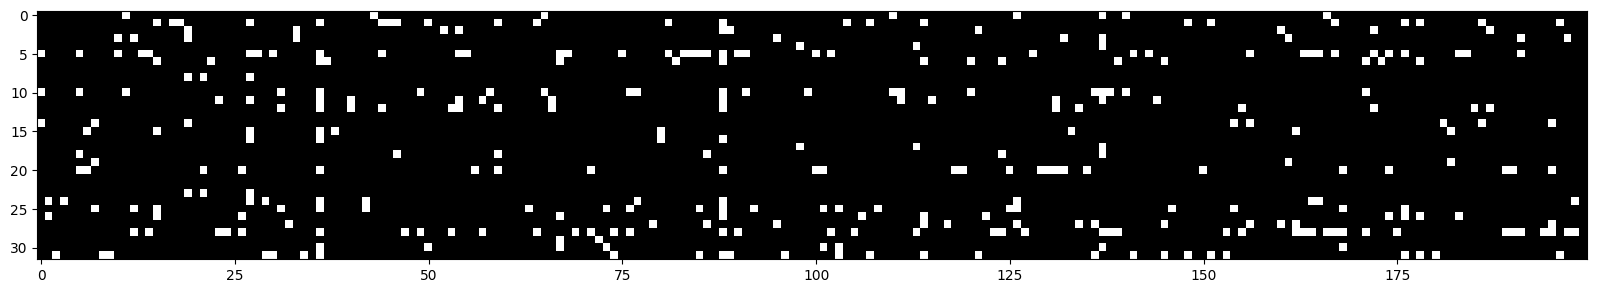

In [13]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap="gray", interpolation="nearest")

In [14]:
@torch.no_grad() # avoid gradient tracking here (no back-propagation)
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val':   (Xdev, Ydev),
        'test':  (Xte, Yte)
    }[split]
    
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1) # concat the vectors
    hpreact = embcat @ W1 + b1          # hidden layer pre-activation
    
    # batch normalization, train and scale
    #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
    hpreact = bngain * (hpreact - bnrunning_mean) / bnrunning_std + bnbias
    
    h = torch.tanh(hpreact)
    
    logits = h @ W2 + b2                # output layer
    loss = F.cross_entropy(logits, y)  # loss function
    print(split, loss.item())
    
split_loss('train')
split_loss('val')

train 2.9265358448028564
val 2.9504737854003906


In [15]:
# sample from our model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size
    while True:
        
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        
        context = context[1:] + [ix]
        out.append(ix)
        
        if ix == 0:
            break
            
    print("".join(itos[i] for i in out))

nbrellequethl.
shbrmylirelly.
sklassafjazcellfernsyha.
prqhif.
quaniftchmihviksleggpvy.
maddis.
quinths.
luvranvanbiylahellyssarisixfkyuspinslivesteppia.
gtrafhastly.
prasmingracsymantellsozswylljssia.
jafrendep.
sadlucoclom.
susolazkryndra.
pllmanransshernyxxnyvanbhdn.
bryndellyssvioslddgprissaldykkmciepazziyaanpe.
khsesustiffamdyevenhy.
qlyctorrowordubransskingty.
zaindzs.
matkellistiner.
sch.


In [16]:
logits = torch.randn(4)
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
probs, loss

(tensor([0.1539, 0.5124, 0.0148, 0.3189]), tensor(4.2151))

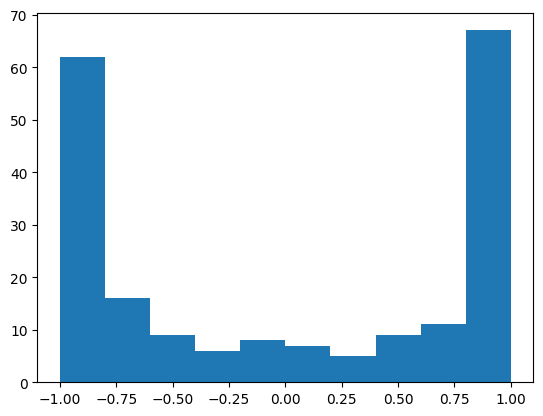

In [17]:
# this is problematic... 
# when we backpropagate, there is no multiplying the gradient
plt.hist(h.view(-1).tolist()); 

In [18]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / 10**0.5
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())

tensor(0.0194) tensor(1.0064)
tensor(-0.0019) tensor(1.0229)


In [19]:
(torch.randn(10000)).std()

tensor(1.0108)

In [20]:
(torch.randn(10000) * 0.2).std()

tensor(0.2008)

In [21]:
fanin = n_embed * block_size
gain = (5/3) / (fanin ** 0.5) # gain for tanh * sqrt of fanin
gain # what we want the standard deviation to be!

0.3042903097250923

In [28]:
''' SUMMARY '''

class Linear:
    
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros((fan_out)) if bias else None
        
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
class BatchNorm1d:
    
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        self.gain = torch.ones(dim)
        self.bias = torch.zeros(dim)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        
    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar  = x.var(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar  = self.running_var
            
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gain * xhat + self.bias
        
        if self.training:
            with torch.no_grad():
                exst_weight = 1 - self.momentum
                self.running_mean = (exst_weight * self.running_mean + self.momentum * xmean)
                self.running_var  = (exst_weight * self.running_var + self.momentum * xvar)

        return self.out
        
    def parameters(self):
        return [self.gain, self.bias]
    
    
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []
    
n_embd = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden),           Tanh(),
    Linear(n_hidden, n_hidden),           Tanh(),
    Linear(n_hidden, n_hidden),           Tanh(),
    Linear(n_hidden, n_hidden),           Tanh(),
    Linear(n_hidden, vocab_size)
]

with torch.no_grad():
    # last layer, make less confident
    layers[-1].weight *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3
            
            
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

46497


In [29]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # create our mini-batch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y
    
    # forward pass
    emb = C[Xb]                         # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concat the vectors
    for layer in layers:
        x = layer(x)

    loss = F.cross_entropy(x, Yb)  # loss function
    
    # backward pass
    for layer in layers:
        layer.out.retain_grad()
        
    for p in parameters:
        p.grad = None
        
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.2962
  10000/ 200000: 2.3341
  20000/ 200000: 2.0329
  30000/ 200000: 1.7318
  40000/ 200000: 2.1077
  50000/ 200000: 2.2376
  60000/ 200000: 1.8693
  70000/ 200000: 2.1074
  80000/ 200000: 2.4302
  90000/ 200000: 1.8251
 100000/ 200000: 2.3480
 110000/ 200000: 2.2027
 120000/ 200000: 2.0362
 130000/ 200000: 1.9721
 140000/ 200000: 1.6542
 150000/ 200000: 1.6816
 160000/ 200000: 1.8606
 170000/ 200000: 1.7056
 180000/ 200000: 2.1490
 190000/ 200000: 1.9208
